# Medicare Claims Analysis

Medicare is USA's largest government insurance program. It caters to US senior citizens aged 65+, and youths with disabilities. The program is adminstered by CMS (Center for Medicare and Medicaid Services). The data linked is from the CMS Website.


### Guidelines for the task
- Take the time to understand the business problem and to develop a thoughtful solution, we suggest taking a few hours to complete the task.
- Be prepared to talk through what you did during the task to a technical & non-technical audience.
- If there are parts of this EDA that you would do differently, or with more time, would try something else, please discuss these during the interview. 
- Please share code & relevant materials (slides, workbooks etc..) at least 24 hours prior to the interview



## Central Question: How does cost vary across different providers for different conditions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
slide_background_color = '#212121'
def set_preferred_options():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
    plt.style.use('dark_background')
    plt.facecolor=(.33, .33, .33)
    matplotlib.rcParams['font.sans-serif'] = "Arial"
    # Then, "ALWAYS use sans-serif fonts"
    matplotlib.rcParams['font.family'] = "sans-serif"
set_preferred_options()

In [3]:

def generate_vertical_bar_graph(df, variable, 
                                chart_title="", 
                                variable_readable="", 
                                variable_labels={}):

    if(not(variable_readable)):
        variable_readable = variable

    if not(variable_labels):
        variable_labels={key: key for key in df[variable].unique().tolist()}
    
    variable_distribution = (df[variable]
                            .value_counts(normalize=True, sort=False) * 100
                            )
    
    fig, ax = plt.subplots(figsize=(6, 4), facecolor=slide_background_color)

    variable_distribution.plot(kind='bar', ax=ax)

    # Adds percentages above the bars
    for i, v in enumerate(variable_distribution):
        ax.text(i, v + 1, 
                f'{int(v)}%', 
                ha='center', 
                va='bottom',
                fontsize=10)

    ax.set_title(f'Distribution of {variable_readable}', fontsize=16, pad=20)
    ax.set_xlabel(variable_readable)

    # Set custom labels for x-axis ticks
    ax.set_xticks(range(len(variable_distribution)))
    ax.set_xticklabels(
        [variable_labels.get(key, key) for key in variable_distribution.index], 
        rotation=0)
    
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.spines['top'].set_visible(False)   
    ax.spines['right'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.set_facecolor(slide_background_color) 
    plt.show()

def generate_horizontal_bar_graph(df, variable, chart_title="", 
                                  variable_readable="", 
                                  variable_labels={}):
    if(not(variable_readable)):
        variable_readable = variable

    if not(variable_labels):
        variable_labels={key: key for key in df[variable].unique().tolist()}

    variable_distribution = (df[variable]
                            .map(variable_labels)
                            .value_counts(normalize=True) * 100

                            )
    variable_distribution.sort_values(ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize=(6, 12), facecolor=slide_background_color)


    variable_distribution.plot(kind='barh', ax=ax)

    # Adds percentages above the bars
    for i, v in enumerate(variable_distribution):
        ax.text(v + 1, i, 
                f'{int(v)}%', 
                ha='left', 
                va='center',
                fontsize=10)

    ax.set_title(f'Distribution of {variable_readable}', 
                 fontsize=16, 
                 pad=20, 
                 loc='center')
    ax.set_ylabel(variable_readable)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.spines['top'].set_visible(False)   
    ax.spines['right'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 
    ax.set_facecolor(slide_background_color) 
    plt.show()


def generate_conditions_summary(df, conditions_readable_map):
    '''
    
    '''
    # Create subplots with one column and as many rows as there are conditions
    num_conditions = len(conditions_readable_map)
    fig, axs = plt.subplots(
        nrows=num_conditions, 
        ncols=1, 
        figsize=(8, 0.45*num_conditions),
        facecolor=slide_background_color
        )
    fig.suptitle('Presence of Chronic Illnesses', fontsize=16)
    for i, (condition_variable_name, condition_contents) in enumerate(conditions_readable_map.items()):
        
        condition_readable_name = condition_contents[0]
        conditions_map = condition_contents[1]

        # Calculate the percentage of 'Yes's in the current condition column
        percentage_condition = (
            df[condition_variable_name]
            .value_counts(normalize=True) * 100
        ).loc[conditions_map['Yes']]

        axs[i].barh([condition_readable_name], [percentage_condition])

        # Display the percentage label at the bottom
        axs[i].text(x=0,
                    y=0,
                    s=f'{condition_readable_name}: {percentage_condition:.0f}% ',
                    ha='right',
                    va='center')
        axs[i].set_xlim(0, 100) 

        axs[i].set_yticks([])
        axs[i].set_xticks([]) 
        axs[i].spines['top'].set_visible(False)   
        axs[i].spines['right'].set_visible(False) 
        axs[i].spines['bottom'].set_visible(False) 
        axs[i].set_facecolor(slide_background_color) 

    # Just want the x axis ticks at the bottom
    axs[num_conditions - 1].set_xticks([20, 40, 60, 80, 100])  

    plt.tight_layout()
    plt.show()

def get_beneficiary_age(df, age_variable, reference_date_str):
    df[age_variable] = pd.to_datetime(df[age_variable], format='%Y%m%d')
    reference_date = datetime.strptime(reference_date_str, '%Y%m%d')
    df['age'] = (reference_date - df[age_variable]).astype('<m8[Y]')

    # Create a new categorical variable 'age_group'
    bins = [-float('inf'), 25, 65, 70, 75, 80, 85, 90, float('inf')]
    ages = ['1','2','3','4','5','6','7','8']

    df['age_group'] = pd.cut(df['age'], 
                             bins=bins, 
                             labels=ages,
                             right=False)
    return df

def customise_graph_dark_mode(axis):
    '''
    Make sure to run this before setting graph titles
    '''
    axis.set_facecolor('black') 
    axis.set_title('Sample Text', color='grey')
    axis.set_xlabel('Sample Text', color='grey')
    axis.set_ylabel('Sample Text', color='grey')
    axis.tick_params(axis='x', colors='grey')  
    axis.tick_params(axis='y', colors='grey')  
    axis.spines['bottom'].set_color('grey') 
    axis.spines['left'].set_color('grey')   
    axis.spines['top'].set_visible(False)   
    axis.spines['right'].set_visible(False) 
    

In [4]:
def get_data(file_path, char_columns):
    dtype_options = {column: "str" for column in char_columns}
    df = pd.read_csv(file_path, dtype=dtype_options)
    return df

In [5]:
THRESHOLD_CONDITIONS = 3
def display_dataframe_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
#     pd.set_option('display.max_colwidth', 100)
    print(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
#     pd.reset_option('display.max_colwidth')

def combine_conditions(row, columns_to_combine):
    ''' columns_to_combine is a dict'''
    conditions = []
    for col in columns_to_combine:
        condition_readable_name = columns_to_combine[col][0]
        conditions_map = columns_to_combine[col][1]

        if row[col] == conditions_map['Yes']:
            conditions.append(condition_readable_name)

    if conditions:
        if len(conditions) >=3:
            return 'Multiple'
        else:
            return ' | '.join(conditions)
    else:
        return 'None'
    
def categorise_multiple(row, columns_to_check):
    count_ones = sum(row[col] == 1 for col in columns_to_check)
    return 'Multiple' if count_ones > 3 else 'None'

def get_illness_var_type(df):
    df['illness_var_type'] = np.where(
    (df['combined_condition'] == 'Multiple') | (df['combined_condition'] == 'None'),
    df['combined_condition'],
    'Combination of 2 illnesses')
    return df



In [6]:
beneficiary_file_path = "./data/DE1_0_2009_Beneficiary_Summary_File_Sample_20.csv"
char_columns_in_beneficiary_data = [
    'BENE_SEX_IDENT_CD',
    'BENE_RACE_CD',
    'BENE_ESRD_IND',
    'SP_ALZHDMTA',
    'SP_CHF',
    'SP_CHRNKIDN',
    'SP_CNCR',
    'SP_COPD',
    'SP_DEPRESSN',
    'SP_DIABETES',
    'SP_ISCHMCHT',
    'SP_OSTEOPRS',
    'SP_RA_OA',
    'SP_STRKETIA'
]	


claims_file_path = "./data/DE1_0_2008_to_2010_Outpatient_Claims_Sample_20.csv"
char_columns_in_claims_data = [
    'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
    'ICD9_DGNS_CD_3','ICD9_DGNS_CD_4' ,'ICD9_DGNS_CD_5',
    'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
    'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
    'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
    'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6'     
]



In [17]:
beneficiary_df = get_data(beneficiary_file_path, 
                          char_columns_in_beneficiary_data)
claims_df = get_data(claims_file_path,
                     char_columns_in_claims_data)

In [18]:
beneficiary_df = get_beneficiary_age(beneficiary_df,
                                     'BENE_BIRTH_DT',
                                     reference_date_str='20101212'
                                     )


In [9]:
def apply_currency_formatting(amount):
    return '${:,.0f}'.format(amount)

In [19]:
conditions_to_combine = {'SP_ALZHDMTA': 'Alzheimer',
                      'SP_CHF': 'Heart Failure',
                      'SP_CHRNKIDN': 'Kidney Disease',
                      'SP_CNCR': 'Cancer',
                      'SP_COPD': 'COPD', 
                      'SP_DEPRESSN': 'Depression',
                      'SP_DIABETES': 'Diabetes',
                      'SP_ISCHMCHT': 'Ischemic Heart Disease',
                      'SP_OSTEOPRS': 'Osteoporosis',
                      'SP_RA_OA': 'Rheumatoid Arthritis or Osteoarthritis',
                      'SP_STRKETIA': 'Stroke'  
}
sp_conditions_map = {
'Yes':'1',
'No':'2'
}
esrd_conditions_map = {
    'No':'0',
    'Yes':'Y'
}
conditions_readable_map = {
    'BENE_ESRD_IND':['End stage renal disease', esrd_conditions_map],
    'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
    'SP_CHF':['Heart Failure', sp_conditions_map],
    'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
    'SP_CNCR':['Cancer', sp_conditions_map],
    'SP_COPD':['Chronic Obstructive Pulmonary Disease', sp_conditions_map],
    'SP_DEPRESSN':['Depression', sp_conditions_map],
    'SP_DIABETES':['Diabetes', sp_conditions_map],
    'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
    'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
    'SP_RA_OA':['Rheumatoid Arthritis or Osteoarthritis', sp_conditions_map],
    'SP_STRKETIA':['Stroke' , sp_conditions_map],
}


beneficiary_df['combined_condition'] = beneficiary_df.apply(combine_conditions, 
                                    columns_to_combine=conditions_readable_map, 
                                    axis=1)
beneficiary_df['combined_condition'].value_counts()
beneficiary_df = get_illness_var_type(beneficiary_df)



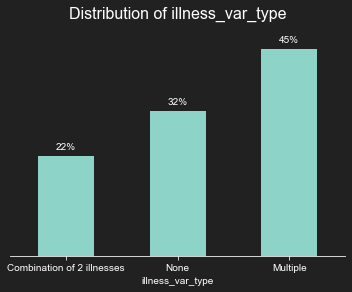

In [11]:
generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="illness_var_type")

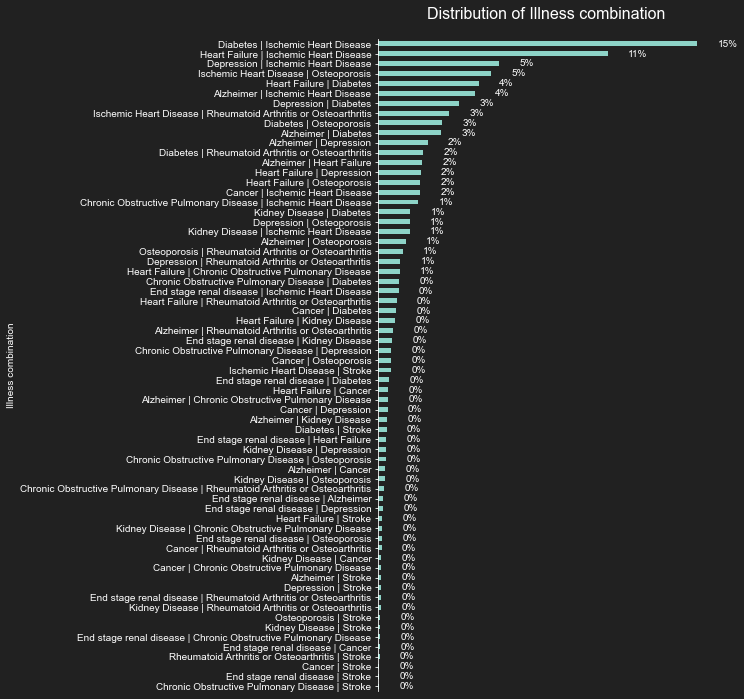

In [13]:
illness_combination_df = beneficiary_df[
    beneficiary_df['combined_condition'].str.contains('\|')
    ]
generate_horizontal_bar_graph(df=illness_combination_df,
                            variable="combined_condition", 
                            chart_title="", 
                            variable_readable="Illness combination")

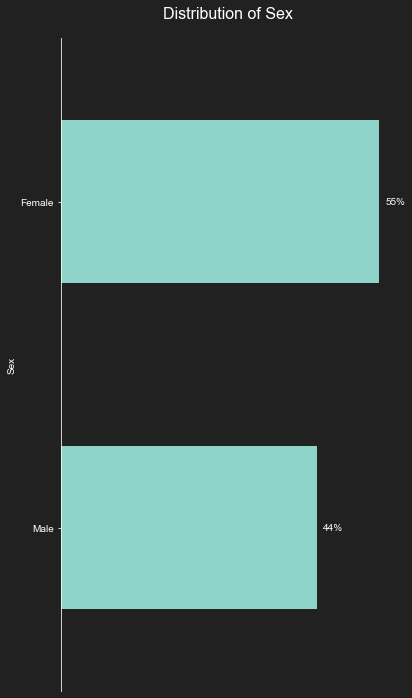

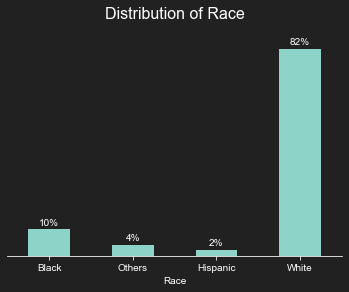

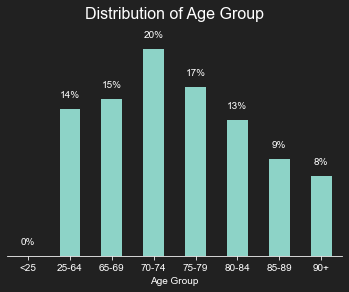

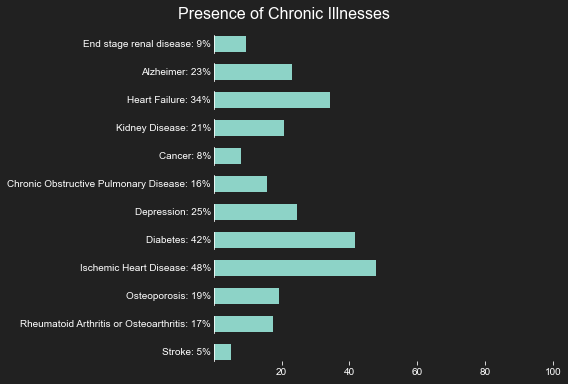

In [14]:
def generate_descriptive_graphs_beneficiary(beneficiary_df):
    sex_labels = {'1':'Male', '2':'Female'}
    race_labels = {'1': 'White', '2': 'Black', '3': 'Others', '5': 'Hispanic'}
    sp_conditions_map = {
    'Yes':'1',
    'No':'2'
    }
    esrd_conditions_map = {
        'No':'0',
        'Yes':'Y'
    }
    conditions_readable_map = {
        'BENE_ESRD_IND':['End stage renal disease', esrd_conditions_map],
        'SP_ALZHDMTA':['Alzheimer', sp_conditions_map],
        'SP_CHF':['Heart Failure', sp_conditions_map],
        'SP_CHRNKIDN':['Kidney Disease', sp_conditions_map],
        'SP_CNCR':['Cancer', sp_conditions_map],
        'SP_COPD':['Chronic Obstructive Pulmonary Disease', sp_conditions_map],
        'SP_DEPRESSN':['Depression', sp_conditions_map],
        'SP_DIABETES':['Diabetes', sp_conditions_map],
        'SP_ISCHMCHT':['Ischemic Heart Disease', sp_conditions_map],
        'SP_OSTEOPRS':['Osteoporosis', sp_conditions_map],
        'SP_RA_OA':['Rheumatoid Arthritis or Osteoarthritis', sp_conditions_map],
        'SP_STRKETIA':['Stroke' , sp_conditions_map],
    }

    age_labels = {
        '1': '<25',
        '2': '25-64',
        '3': '65-69',
        '4': '70-74',
        '5': '75-79',
        '6': '80-84',
        '7': '85-89',
        '8': '90+',
    }

    
    generate_horizontal_bar_graph(df=beneficiary_df, 
                            variable="BENE_SEX_IDENT_CD",
                            chart_title="",
                            variable_readable="Sex",
                            variable_labels=sex_labels)
    
    generate_vertical_bar_graph(df=beneficiary_df, 
                            variable="BENE_RACE_CD",
                            chart_title="",
                            variable_readable="Race",
                            variable_labels=race_labels)
    
    generate_vertical_bar_graph(df=beneficiary_df, 
                        variable="age_group",
                        variable_readable="Age Group",
                        chart_title="",
                        variable_labels=age_labels)
    
    generate_conditions_summary(beneficiary_df, conditions_readable_map)
    
generate_descriptive_graphs_beneficiary(beneficiary_df)

### 2. Data Cleaning
The beneficiary summary file has several chronic illness columns for each member. These are Boolean fields.

- Convert these columns into a single categorical variable, concatenating multiple true diagnoses.

- If a member has 3 or more chronic conditions, categorise these as “Multiple”
- Join claims & benefit data

### Data Quality checks

- Beneficiary data is unique at `DESYNPUF_ID` - which represents the beneficiary code/ patient code according to documentation${^1}$

- The claims data is not unique on `CLM_ID`. However it is unique at `CLM_ID` x `Segment` level.
Wherever segment = 2, most of the variables are `NaN`s, excepting Provider Institution. From looking at this data, my hypothesis is that the claims were amended, with a new Provider Info, or claim amount. For this analysis, I'm dropping the rows where the segment = 2, and most of the variables are `NaN`

- There are some claims where the `CLM_PMT_AMT` is negative, which can occur in
the following cases:
    - Where the beneficiary is charged a coinsurance amount and this is higher than the amount Medicare pays
    - Where the deductible exceeds the amount Medicare pays
    
    In both the above situations the claim amount does not represent the cost of the treatment, hence this has been removed from the dataset

- `MEDREIMB_OP` in the beneficiary dataset denotes the total annual medical Outpatient Reimbursement from Medicaid. There are some beneficiaries in the dataset that have negative due to similar reasons as for `CLM_PMT_AMT`. However these are not removed, as their could be non-negative claim amounts from the same benficiary. I've replaced negative values with
0 for this dataset.



In [20]:
claims_df = claims_df.drop_duplicates(subset=['CLM_ID'])
claims_df = claims_df[claims_df['CLM_PMT_AMT'] >= 0]
duplicate_claims = claims_df[claims_df.duplicated(subset=['CLM_ID'], keep=False)]
beneficiary_df['MEDREIMB_OP'][beneficiary_df['MEDREIMB_OP'] < 0] = 0

# claims_df = claims_df[~claims_df.duplicated(subset=['CLM_ID'], keep=False)]

/Users/anjalikarimpil/projects/takehome-challenges/UHG-DS/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Data joining

In [52]:
print("# of rows in beneficiary data", len(beneficiary_df))
print("# of rows in claims data", len(claims_df))
beneficiary_claims_df = pd.merge(beneficiary_df, claims_df, 
                                 on='DESYNPUF_ID', how='inner')
print('# of rows in joined data',len(beneficiary_claims_df))

# of rows in beneficiary data 114641
# of rows in claims data 776670
# of rows in joined data 774693


In [41]:
merged_df = pd.merge(beneficiary_df, claims_df, on='DESYNPUF_ID', how='outer', indicator=True)

claims_missing_beneficiary = merged_df[merged_df['_merge'] == 'right_only']
beneficiary_missing_claims = merged_df[merged_df['_merge'] == 'left_only']
print(f"Beneficiaries without claims: {len(beneficiary_missing_claims)}")
print(f"Claims without beneficiaries: {len(claims_missing_beneficiary)}")

Beneficiaries without claims: 30077
Claims without beneficiaries: 1977


In [51]:
beneficiary_missing_claims.loc[:,'TOTAL_SUM'] = (
    beneficiary_missing_claims['MEDREIMB_IP'] + 
    beneficiary_missing_claims['MEDREIMB_CAR']
)
beneficiary_missing_claims['missing_reason'] = np.where(
    (beneficiary_missing_claims['TOTAL_SUM'] > 0),
    "Has other claims",
    "Missing claims")

beneficiary_missing_claims['missing_reason'] = np.where(
    (beneficiary_missing_claims['combined_condition'] == 'None'),
    "No illnesses",
    "Missing claims")
beneficiary_missing_claims['missing_reason'].value_counts()

No illnesses      25997
Missing claims     4080
Name: missing_reason, dtype: int64

### Data quality after join
- There are 30,077 beneficiaries that do not have any claims, and 86% of them 
has no chronic illness.
- There are ~2k OP claims without beneficiaries, which is 0.25% of the data.

Onward with the remaining analysis!

Which chronic illness combination has the total highest cost?
Which chronic illness combination has the highest cost per member?


### Benchmarking

The aim here is to understand the distribution of cost across providers treating members with these chronic illnesses. Benchmarking providers across types of care is often a helpful starting point to begin solutioning for areas of high cost.

For each provider (use AT_PHYSN_NPI) & chronic illness, calculate the cost per member.
For each chronic illness combination, represent the distribution of costs per provider.
How does this change if we filter out cases where a given Chronic Illness & Provider NPI combination only has 1 member?
Which providers are consistently expensive across chronic illnesses they treat?


In [70]:

condition_grouped_df = beneficiary_claims_df.groupby('combined_condition').agg(
    total_cost=('CLM_PMT_AMT', 'sum'),
    beneficiary_count=('DESYNPUF_ID', 'nunique'),  
    claim_count=('CLM_ID', 'count')  
).reset_index()

condition_grouped_df['cost_per_member_per_illness'] = (condition_grouped_df['total_cost'] / 
                                                       condition_grouped_df['beneficiary_count'])

condition_grouped_df.sort_values(by='total_cost', 
                                 ascending=False, 
                                 inplace=True)

condition_grouped_df.head(20)

,combined_condition,total_cost,beneficiary_count,claim_count,cost_per_member_per_illness
72,Multiple,169465320.00,51333,597369,3301.29
73,None,7507760.00,10802,34928,695.03
59,Ischemic Heart Disease,4154450.00,3409,18609,1218.67
33,Diabetes | Ischemic Heart Disease,2941930.00,1856,13642,1585.09
32,Diabetes,2250410.00,1673,10729,1345.13
54,Heart Failure | Ischemic Heart Disease,1891530.00,1286,8884,1470.86
26,Depression,1412450.00,1186,6623,1190.94
49,Heart Failure,1158360.00,1131,5641,1024.19
28,Depression | Ischemic Heart Disease,1102670.00,694,4906,1588.86
74,Osteoporosis,1066700.00,972,5184,1097.43


In [ ]:
member_grouped_df = (beneficiary_claims_df
                     .groupby(['DESYNPUF_ID', 'combined_condition'])
                     .agg(physician_count=['AT_PHYSN_NPI', 'nunique']
                          cost=['CLM_PMT_AMT', 'sum']
                          )
                    )
(member_grouped_df
 .groupby(['combine_condition'])
 .agg(num_physicians=['physician_count', 'sum'],
      median_cost_per_member_per_illness=['cost', 'median']
      
      )
 )

In [71]:
provider_condition_grouped_df = (beneficiary_claims_df
                                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])
                                 .agg(total_cost=('CLM_PMT_AMT', 'sum'),
                                     beneficiary_count=('DESYNPUF_ID', 'nunique'),
                                    )
                                ).reset_index()

provider_condition_grouped_df['cost_per_member_per_provider'] = (
    provider_condition_grouped_df['total_cost'] / 
    provider_condition_grouped_df['beneficiary_count'])

provider_condition_grouped_df.sort_values(by='cost_per_member_per_provider', 
                                 ascending=False, 
                                 inplace=True)

provider_condition_grouped_df.head(20)

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member_per_provider
89716,4434265417.00,Ischemic Heart Disease | Osteoporosis,7920.00,1,7920.00
47376,2371639354.00,Rheumatoid Arthritis or Osteoarthritis,7680.00,1,7680.00
13667,682792263.00,Diabetes | Rheumatoid Arthritis or Osteoarthritis,7490.00,1,7490.00
199847,9943567290.00,End stage renal disease | Rheumatoid Arthritis...,7420.00,1,7420.00
116978,5811236759.00,Diabetes | Rheumatoid Arthritis or Osteoarthritis,6600.00,1,6600.00
72851,3600937944.00,Rheumatoid Arthritis or Osteoarthritis | Stroke,6290.00,1,6290.00
66620,3304695316.00,Multiple,6270.00,1,6270.00
99034,4902260259.00,Alzheimer | Depression,6240.00,1,6240.00
34238,1710533109.00,Heart Failure | Ischemic Heart Disease,6220.00,1,6220.00
54222,2713175762.00,Heart Failure | Diabetes,6020.00,1,6020.00


In [54]:
grouped_stats_df = pd.merge(provider_condition_grouped_df, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['cost_per_member_per_illness'] - grouped_stats_df['cost_per_member_per_provider']
grouped_stats_df
grouped_stats_df = grouped_stats_df[grouped_stats_df['beneficiary_count_x'] > 1]

grouped_stats_df.sort_values(by=['AT_PHYSN_NPI','diff'], ascending=False)

,AT_PHYSN_NPI,combined_condition,total_cost_x,beneficiary_count_x,cost_per_member_per_provider,total_cost_y,beneficiary_count_y,claim_count,cost_per_member_per_illness,diff
98344,9999469755.00,Multiple,50.00,2,25.00,168373920.00,50729,594603,3319.09,3294.09
98343,9999354704.00,Multiple,4620.00,8,577.50,168373920.00,50729,594603,3319.09,2741.59
98342,9999234722.00,Multiple,180.00,3,60.00,168373920.00,50729,594603,3319.09,3259.09
98339,9999039484.00,Multiple,550.00,5,110.00,168373920.00,50729,594603,3319.09,3209.09
98338,9999035093.00,Multiple,280.00,3,93.33,168373920.00,50729,594603,3319.09,3225.75
...,...,...,...,...,...,...,...,...,...,...
10606,1159725.00,Multiple,3500.00,3,1166.67,168373920.00,50729,594603,3319.09,2152.42
10605,1053861.00,Multiple,8670.00,18,481.67,168373920.00,50729,594603,3319.09,2837.42
10604,1005544.00,Multiple,790.00,10,79.00,168373920.00,50729,594603,3319.09,3240.09
10600,511156.00,Multiple,160.00,2,80.00,168373920.00,50729,594603,3319.09,3239.09


In [30]:

# Filter out cases where there is only 1 member
provider_condition_grouped_df = provider_condition_grouped_df[provider_condition_grouped_df['beneficiary_count'] > 1]

# Calculate cost per member and add it to the DataFrame
provider_condition_grouped_df['cost_per_member'] = (

    provider_condition_grouped_df['total_cost'] / 
    provider_condition_grouped_df['beneficiary_count'])

provider_condition_grouped_df

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member
1,102408.00,Multiple,2220.00,4,555.00
3,511156.00,Multiple,160.00,2,80.00
12,1005544.00,Multiple,790.00,10,79.00
19,1053861.00,Multiple,8670.00,18,481.67
21,1159725.00,Multiple,3500.00,3,1166.67
...,...,...,...,...,...
204380,9999035093.00,Multiple,280.00,3,93.33
204381,9999039484.00,Multiple,550.00,5,110.00
204386,9999234722.00,Multiple,180.00,3,60.00
204387,9999354704.00,Multiple,4620.00,8,577.50


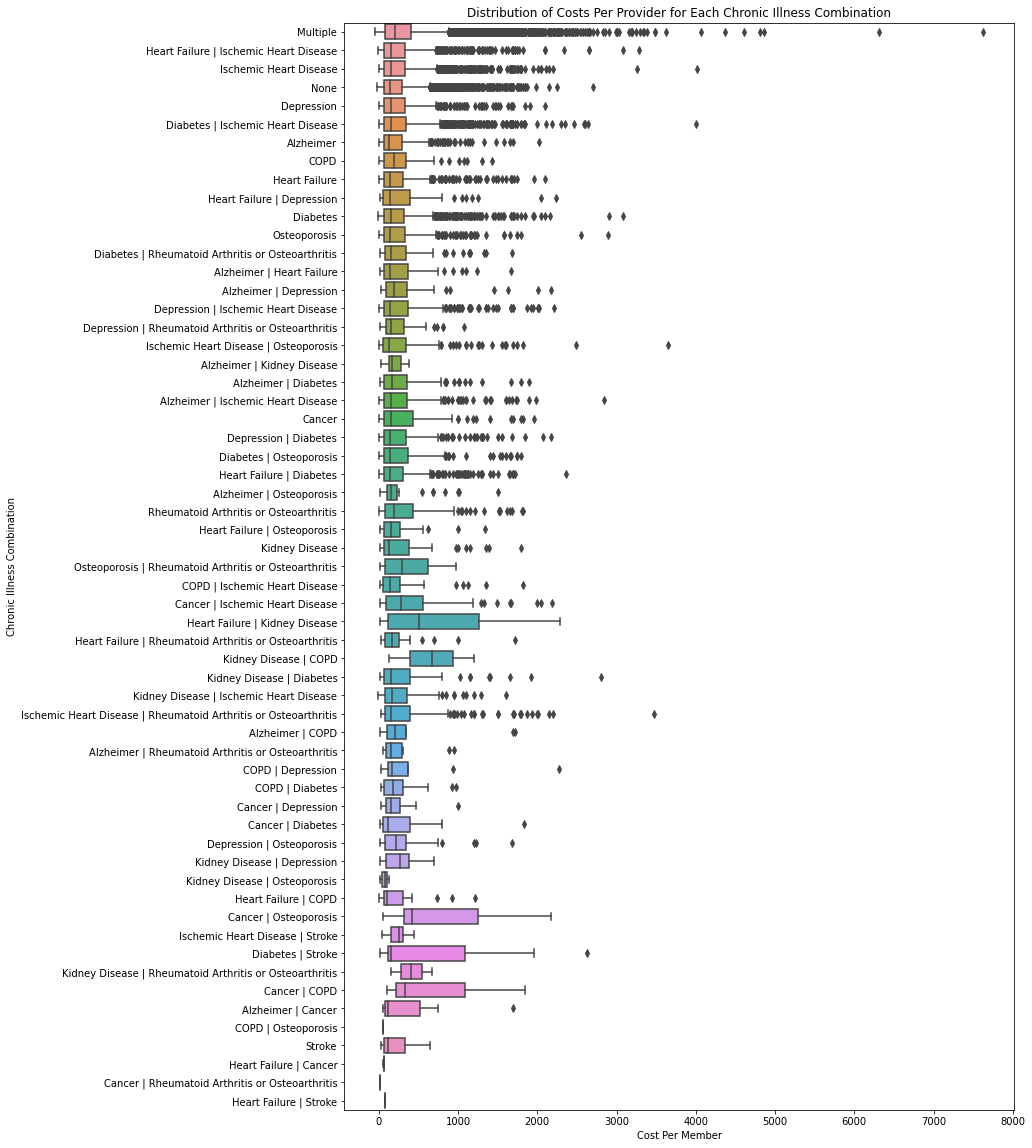

In [19]:

# Create a horizontal boxplot using seaborn
plt.figure(figsize=(12, 20))
sns.boxplot(x='cost_per_member', y='combined_condition', data=provider_condition_grouped_df)

# Customize the plot
plt.title('Distribution of Costs Per Provider for Each Chronic Illness Combination')
plt.xlabel('Cost Per Member')
plt.ylabel('Chronic Illness Combination')

# Show the plot
plt.show()


In [20]:
filtered_df = beneficiary_claims_df[
    (provider_condition_grouped_df['combined_condition'] != 'Multiple') & 
    (provider_condition_grouped_df['combined_condition'] != 'None')
    ].sort_values(by=['AT_PHYSN_NPI', 'combined_condition'])


Providers Consistently Expensive Across Chronic Illnesses (Lowest Standard Deviation):
                                   combined_condition  cost_per_member
31                                  Diabetes | Stroke          1077.22
16                                      Cancer | COPD           948.08
47                              Kidney Disease | COPD           760.14
38                     Heart Failure | Kidney Disease           739.12
11                                  COPD | Depression           725.49
20                              Cancer | Osteoporosis           725.46
1                                    Alzheimer | COPD           687.15
2                                  Alzheimer | Cancer           607.29
44  Ischemic Heart Disease | Rheumatoid Arthritis ...           519.22
49                          Kidney Disease | Diabetes           484.24
19                    Cancer | Ischemic Heart Disease           480.90
18                                  Cancer | Diabetes        

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member
39,2258359.00,Heart Failure | Ischemic Heart Disease,1030.00,2,515.00
40,2258359.00,Ischemic Heart Disease,830.00,2,415.00
66,3873846.00,Depression,80.00,2,40.00
124,7369113.00,Ischemic Heart Disease,100.00,2,50.00
145,8234489.00,Ischemic Heart Disease,1280.00,2,640.00
...,...,...,...,...,...
204124,9983663018.00,Ischemic Heart Disease,1140.00,2,570.00
204163,9986377632.00,Diabetes | Ischemic Heart Disease,50.00,2,25.00
204197,9989157751.00,Diabetes | Rheumatoid Arthritis or Osteoarthritis,600.00,2,300.00
204212,9989872252.00,Heart Failure,170.00,2,85.00


In [22]:
(provider_condition_grouped_df
 .sort_values(by=['AT_PHYSN_NPI', 'combined_condition']))

,AT_PHYSN_NPI,combined_condition,total_cost,beneficiary_count,cost_per_member
1,102408.00,Multiple,2220.00,4,555.00
3,511156.00,Multiple,160.00,2,80.00
12,1005544.00,Multiple,790.00,10,79.00
19,1053861.00,Multiple,8670.00,18,481.67
21,1159725.00,Multiple,3500.00,3,1166.67
...,...,...,...,...,...
204380,9999035093.00,Multiple,280.00,3,93.33
204381,9999039484.00,Multiple,550.00,5,110.00
204386,9999234722.00,Multiple,180.00,3,60.00
204387,9999354704.00,Multiple,4620.00,8,577.50


In [42]:
grouped_stats = (filtered_df
                 .groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member']
                 .agg(['mean', 'median', 'std', 'count'])
                 .reset_index())
grouped_stats_df = pd.merge(grouped_stats, condition_grouped_df, on=['combined_condition'])
# grouped_stats_df = grouped_stats_df.drop(['total_cost', 'beneficiary_count', 'claim_count'], axis=1)
grouped_stats_df['diff'] = grouped_stats_df['median'] - grouped_stats_df['cost_per_member']


grouped_stats_df.sort_values(by=['diff'], ascending=False)

            

,AT_PHYSN_NPI,combined_condition,mean,median,std,count,cost_per_member,diff
1128,682792263.00,Ischemic Heart Disease,4015.00,4015.00,nan,1,1218.24,2796.76
4934,5088396912.00,Diabetes | Ischemic Heart Disease,4005.00,4005.00,nan,1,1595.07,2409.93
9432,1507715206.00,Ischemic Heart Disease | Osteoporosis,3645.00,3645.00,nan,1,1404.68,2240.32
3010,8330940486.00,Ischemic Heart Disease,3260.00,3260.00,nan,1,1218.24,2041.76
12157,8244465611.00,Ischemic Heart Disease | Rheumatoid Arthritis ...,3475.00,3475.00,nan,1,1626.60,1848.40
...,...,...,...,...,...,...,...,...
11815,865386227.00,Kidney Disease | Diabetes,25.00,25.00,nan,1,2466.00,-2441.00
11885,9920136071.00,Kidney Disease | Diabetes,25.00,25.00,nan,1,2466.00,-2441.00
11825,1874552565.00,Kidney Disease | Diabetes,20.00,20.00,nan,1,2466.00,-2446.00
11812,524431244.00,Kidney Disease | Diabetes,10.00,10.00,nan,1,2466.00,-2456.00


In [44]:
# Filter groups with count greater than 1
grouped_stats_filtered = grouped_stats_df[grouped_stats_df['count'] > 1]

# Reset index after filtering
grouped_stats_filtered = grouped_stats_filtered.reset_index(drop=True)
grouped_stats_filtered.sort_values(by=['diff'], ascending=False)

,AT_PHYSN_NPI,combined_condition,mean,median,std,count,cost_per_member,diff


In [60]:
average_cost_per_provider = provider_condition_grouped_df.groupby(['AT_PHYSN_NPI', 'combined_condition'])['cost_per_member_per_provider'].mean().reset_index()

# Step 2: Identify providers with consistently high average costs across chronic illnesses
consistently_expensive_providers = average_cost_per_provider.groupby('AT_PHYSN_NPI')['cost_per_member_per_provider'].mean().sort_values(ascending=False)

# Display the results
print(consistently_expensive_providers.head(50))

AT_PHYSN_NPI
9453890658.00   7630.00
3304695316.00   6270.00
5532434557.00   6100.00
5065277402.00   5200.00
2851549369.00   5100.00
8784806690.00   4064.00
2552137585.00   3600.00
6845950794.00   3490.00
2888845858.00   3430.00
4853184048.00   3400.00
5968076347.00   3390.00
3499575906.00   3320.00
7926849493.00   3320.00
7913110990.00   3300.00
3748050683.00   3300.00
5492984529.00   3300.00
5649515602.00   3300.00
9839603672.00   3300.00
3714969518.00   3300.00
1780551677.00   3300.00
9718434535.00   3300.00
3015790154.00   3300.00
758688883.00    3300.00
6319147644.00   3300.00
4836022017.00   3300.00
5377555873.00   3300.00
6270549830.00   3300.00
3750646945.00   3300.00
3943201081.00   3300.00
6440100449.00   3300.00
9077125405.00   3300.00
2480969570.00   3300.00
5935194709.00   3300.00
5195268143.00   3300.00
7582271488.00   3300.00
8741926060.00   3300.00
460397080.00    3300.00
3291568729.00   3300.00
6214557395.00   3300.00
3739978132.00   3300.00
4240972019.00   3300.00
454

### References
1. CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/SynPUF_DUG.pdf]
2. Codebook for CMS Linkable 2008–2010 Medicare DE-SynPUF [https://www.cms.gov/files/document/de-10-codebook.pdf-0]